In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Dense, BatchNormalization
from keras.utils import to_categorical
import tensorflow as tf

# --- SETTINGS ---
base_dir = r"C:\Users\zezom\PycharmProjects\HorusEye"
dl_ready_dir = os.path.join(base_dir, "Data", "Processed", "DL_ready")
labels_path = os.path.join(base_dir, "train.csv")
ssvep_labels = ['Forward', 'Backward', 'Left', 'Right']  # Adjust as needed

# --- LOAD LABELS CSV & CLEAN COLUMN HEADERS ---
labels_df = pd.read_csv(labels_path)
labels_df.columns = labels_df.columns.str.strip()  # Remove any trailing/leading whitespace
print("CSV columns:", labels_df.columns.tolist())

# --- SELECT ONLY SSVEP DATA ---
if 'paradigm' in labels_df.columns:
    # Filter by paradigm and label
    ssvep_df = labels_df[
        (labels_df['paradigm'].str.strip() == 'SSVEP') &
        (labels_df['label'].isin(ssvep_labels))
    ]
else:
    # No paradigm column: filter by label only
    ssvep_df = labels_df[labels_df['label'].isin(ssvep_labels)]

print(f"Total SSVEP trials found: {len(ssvep_df)}")

# --- LOAD EEG DATA EPOCHS ---
X = []
y = []
missing_files = []

for i, row in ssvep_df.iterrows():
    subject = str(row['subject_id']).strip()
    session = str(row['trial_session']).strip()
    trial_num = int(row['trial'])  # 1-based index
    label = row['label'].strip()

    npy_path = os.path.join(dl_ready_dir, f"{subject}_{session}_EEGdata_preprocessed_DLready.npy")
    if not os.path.exists(npy_path):
        missing_files.append(npy_path)
        continue

    epochs = np.load(npy_path)  # (n_trials, n_channels, n_samples)
    if trial_num - 1 >= epochs.shape[0]:
        print(f"Warning: trial {trial_num} out of range in file {npy_path}")
        continue

    X.append(epochs[trial_num - 1])
    y.append(label)

if len(X) == 0:
    raise RuntimeError("No SSVEP samples found! Check your preprocessed .npy files and label filtering.")

X = np.stack(X)  # (num_trials, n_channels, n_samples)
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# --- PREPARE FOR DEEP LEARNING ---
# Transpose to (samples, timesteps, channels) for Conv1D/LSTM
X = np.transpose(X, (0, 2, 1))
y_cat = to_categorical(y_enc, num_classes=num_classes)

# --- TRAIN/VAL SPLIT ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_enc
)

print("X_train:", X_train.shape, "X_val:", X_val.shape)
print("Classes:", label_encoder.classes_)

# --- MODEL ---
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

model.add(LSTM(128, return_sequences=False))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- TRAINING ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    ]
)

# --- RESULTS ---
if missing_files:
    print(f"Warning: {len(missing_files)} .npy files were missing, e.g. {missing_files[:3]}")

val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_acc:.4f}")


CSV columns: ['id', 'subject_id', 'task', 'trial_session', 'trial', 'label']
Total SSVEP trials found: 4800
X_train: (3451, 2250, 3) X_val: (863, 2250, 3)
Classes: ['Backward' 'Forward' 'Left' 'Right']


C:\Users\zezom\miniconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 2244, 64)       │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2244, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 1122, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1122, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1118, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1118, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 559, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 559, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 557, 256)       │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 557, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 278, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 278, 256)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 348,484 (1.33 MB)

 Trainable params: 347,588 (1.33 MB)

 Non-trainable params: 896 (3.50 KB)

Epoch 1/50
 70/108 ━━━━━━━━━━━━━━━━━━━━ 19s 510ms/step - accuracy: 0.3480 - loss: 1.3772

KeyboardInterrupt: 

In [2]:
import os
import pickle

# --- Define save paths ---
ssvep_model_path = os.path.join(base_dir, "ssvep_model.keras")
ssvep_encoder_path = os.path.join(base_dir, "ssvep_label_encoder.pkl")

# --- Save the trained SSVEP model (Keras format) ---
model.save(ssvep_model_path)
print(f"SSVEP model saved to: {ssvep_model_path}")

# --- Save the LabelEncoder object for later decoding ---
with open(ssvep_encoder_path, "wb") as f:
    pickle.dump(label_encoder, f)
print(f"SSVEP label encoder saved to: {ssvep_encoder_path}")


SSVEP model saved to: C:\Users\zezom\PycharmProjects\HorusEye\ssvep_model.keras
SSVEP label encoder saved to: C:\Users\zezom\PycharmProjects\HorusEye\ssvep_label_encoder.pkl


# EEG transformer

In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import tensorflow as tf

from keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D, Add
from keras.models import Model

# --- SETTINGS ---
base_dir = r"C:\Users\zezom\PycharmProjects\HorusEye"
dl_ready_dir = os.path.join(base_dir, "Data", "Processed", "DL_ready")
labels_path = os.path.join(base_dir, "train.csv")
ssvep_labels = ['Forward', 'Backward', 'Left', 'Right']

# --- LOAD LABELS CSV & CLEAN COLUMN HEADERS ---
labels_df = pd.read_csv(labels_path)
labels_df.columns = labels_df.columns.str.strip()
print("CSV columns:", labels_df.columns.tolist())

# --- SELECT ONLY SSVEP DATA ---
if 'paradigm' in labels_df.columns:
    ssvep_df = labels_df[
        (labels_df['paradigm'].str.strip() == 'SSVEP') &
        (labels_df['label'].isin(ssvep_labels))
    ]
else:
    ssvep_df = labels_df[labels_df['label'].isin(ssvep_labels)]

print(f"Total SSVEP trials found: {len(ssvep_df)}")

# --- LOAD EEG DATA EPOCHS ---
X = []
y = []
missing_files = []

for i, row in ssvep_df.iterrows():
    subject = str(row['subject_id']).strip()
    session = str(row['trial_session']).strip()
    trial_num = int(row['trial'])  # 1-based index
    label = row['label'].strip()

    npy_path = os.path.join(dl_ready_dir, f"{subject}_{session}_EEGdata_preprocessed_DLready.npy")
    if not os.path.exists(npy_path):
        missing_files.append(npy_path)
        continue

    epochs = np.load(npy_path)  # (n_trials, n_channels, n_samples)
    if trial_num - 1 >= epochs.shape[0]:
        print(f"Warning: trial {trial_num} out of range in file {npy_path}")
        continue

    X.append(epochs[trial_num - 1])
    y.append(label)

if len(X) == 0:
    raise RuntimeError("No SSVEP samples found! Check your preprocessed .npy files and label filtering.")

X = np.stack(X)  # (num_trials, n_channels, n_samples)
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)

# --- PREPARE FOR DEEP LEARNING ---
# Transpose to (samples, timesteps, channels) for Conv1D/LSTM/Transformer
X = np.transpose(X, (0, 2, 1))
y_cat = to_categorical(y_enc, num_classes=num_classes)

# --- TRAIN/VAL SPLIT ---
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_enc
)

print("X_train:", X_train.shape, "X_val:", X_val.shape)
print("Classes:", label_encoder.classes_)

# --- EEG Transformer MODEL ---
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.3):
    x = MultiHeadAttention(num_heads=num_heads, key_dim=head_size, dropout=dropout)(inputs, inputs)
    x = Dropout(dropout)(x)
    x = Add()([x, inputs])
    x = LayerNormalization(epsilon=1e-6)(x)
    x_ff = Dense(ff_dim, activation="relu")(x)
    x_ff = Dropout(dropout)(x_ff)
    x_ff = Dense(inputs.shape[-1])(x_ff)
    x = Add()([x, x_ff])
    x = LayerNormalization(epsilon=1e-6)(x)
    return x

input_shape = (X.shape[1], X.shape[2])
inputs = Input(shape=input_shape)
x = transformer_encoder(inputs, head_size=32, num_heads=4, ff_dim=64, dropout=0.3)
x = transformer_encoder(x, head_size=32, num_heads=4, ff_dim=64, dropout=0.3)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()

# --- TRAINING ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
    ]
)

# --- RESULTS ---
if missing_files:
    print(f"Warning: {len(missing_files)} .npy files were missing, e.g. {missing_files[:3]}")

val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}")

train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Accuracy: {train_acc:.4f}")


CSV columns: ['id', 'subject_id', 'task', 'trial_session', 'trial', 'label']
Total SSVEP trials found: 4800
X_train: (3451, 2250, 3) X_val: (863, 2250, 3)
Classes: ['Backward' 'Forward' 'Left' 'Right']


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 2250, 3)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2250, 3)   │      1,923 │ input_layer[0][0… │
│ (MultiHeadAttentio… │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2250, 3)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2250, 3)   │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 2250, 3)   │          6 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2250, 64)  │        256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 2250, 64)  │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 2250, 3)   │        195 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2250, 3)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2250, 3)   │          6 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2250, 3)   │      1,923 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 2250, 3)   │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 2250, 3)   │          0 │ dropout_4[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2250, 3)   │          6 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2250, 64)  │        256 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 2250, 64)  │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2250, 3)   │        195 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 2250, 3)   │          0 │ layer_normalizat… │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2250, 3)   │          6 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 5,288 (20.66 KB)

 Trainable params: 5,288 (20.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


KeyboardInterrupt: 

# EEGNet

Trial 12 Complete [00h 03m 42s]
val_accuracy: 0.39049825072288513

Best val_accuracy So Far: 0.39049825072288513
Total elapsed time: 01h 24m 06s
Epoch 1/100


C:\Users\zezom\miniconda3\Lib\site-packages\keras\src\saving\saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


108/108 - 11s - 103ms/step - accuracy: 0.3695 - loss: 1.3024 - val_accuracy: 0.3847 - val_loss: 1.2932 - learning_rate: 2.0000e-04
Epoch 2/100
108/108 - 9s - 86ms/step - accuracy: 0.3915 - loss: 1.2991 - val_accuracy: 0.3720 - val_loss: 1.2870 - learning_rate: 2.0000e-04
Epoch 3/100
108/108 - 8s - 71ms/step - accuracy: 0.3761 - loss: 1.2927 - val_accuracy: 0.3731 - val_loss: 1.2881 - learning_rate: 2.0000e-04
Epoch 4/100
108/108 - 7s - 68ms/step - accuracy: 0.3799 - loss: 1.2936 - val_accuracy: 0.3650 - val_loss: 1.2925 - learning_rate: 2.0000e-04
Epoch 5/100
108/108 - 8s - 76ms/step - accuracy: 0.3796 - loss: 1.2844 - val_accuracy: 0.3708 - val_loss: 1.2868 - learning_rate: 2.0000e-04
Epoch 6/100
108/108 - 8s - 72ms/step - accuracy: 0.3848 - loss: 1.2769 - val_accuracy: 0.3627 - val_loss: 1.2860 - learning_rate: 2.0000e-04
Epoch 7/100
108/108 - 7s - 67ms/step - accuracy: 0.3834 - loss: 1.2765 - val_accuracy: 0.3592 - val_loss: 1.2900 - learning_rate: 2.0000e-04
Epoch 8/100
108/108 - 7

Best Validation Accuracy: 0.3604
Training Accuracy: 0.4219


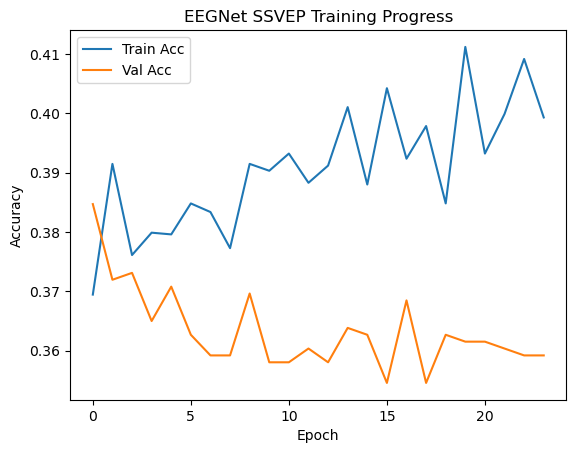

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


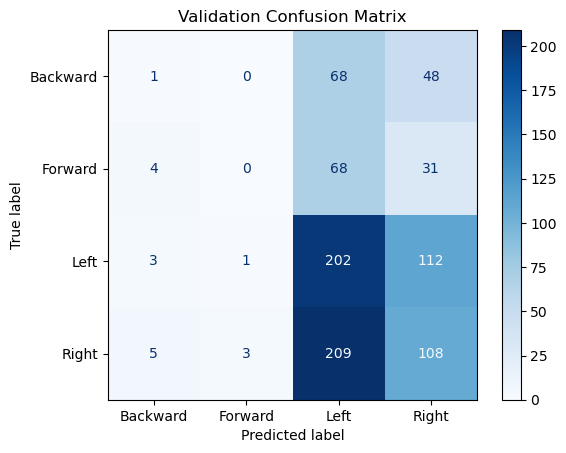

In [4]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D,
                         BatchNormalization, Activation, AveragePooling2D,
                         Dropout, Flatten, Dense)
from keras.models import Model
import matplotlib.pyplot as plt
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# --- SETTINGS ---
base_dir = r"C:\Users\zezom\PycharmProjects\HorusEye"
dl_ready_dir = os.path.join(base_dir, "Data", "Processed", "DL_ready")
labels_path = os.path.join(base_dir, "train.csv")
ssvep_labels = ['Forward', 'Backward', 'Left', 'Right']

# --- LOAD LABELS ---
labels_df = pd.read_csv(labels_path)
labels_df.columns = labels_df.columns.str.strip()

if 'paradigm' in labels_df.columns:
    ssvep_df = labels_df[
        (labels_df['paradigm'].str.strip() == 'SSVEP') &
        (labels_df['label'].isin(ssvep_labels))
    ]
else:
    ssvep_df = labels_df[labels_df['label'].isin(ssvep_labels)]

print(f"Total SSVEP trials found: {len(ssvep_df)}")

# --- LOAD DATA ---
X, y, missing_files = [], [], []
for i, row in ssvep_df.iterrows():
    subject = str(row['subject_id']).strip()
    session = str(row['trial_session']).strip()
    trial_num = int(row['trial'])
    label = row['label'].strip()
    npy_path = os.path.join(dl_ready_dir, f"{subject}_{session}_EEGdata_preprocessed_DLready.npy")
    if not os.path.exists(npy_path):
        missing_files.append(npy_path)
        continue
    epochs = np.load(npy_path)
    if trial_num - 1 >= epochs.shape[0]:
        print(f"Warning: trial {trial_num} out of range in file {npy_path}")
        continue
    X.append(epochs[trial_num - 1])
    y.append(label)
if len(X) == 0:
    raise RuntimeError("No SSVEP samples found! Check your files and label filtering.")
X = np.stack(X)  # (num_trials, n_channels, n_samples)
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)
num_classes = len(label_encoder.classes_)
X = X[..., np.newaxis]    # (num_trials, n_channels, n_samples, 1)
y_cat = to_categorical(y_enc, num_classes=num_classes)
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_enc
)
print("X_train:", X_train.shape, "X_val:", X_val.shape)
print("Classes:", label_encoder.classes_)

# --- EEGNet DEFINITION ---
def EEGNet(nb_classes, Chans=8, Samples=1750, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16):
    input1 = Input(shape=(Chans, Samples, 1))
    x = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input1)
    x = BatchNormalization()(x)
    x = DepthwiseConv2D((Chans, 1), use_bias=False, depth_multiplier=D, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 4))(x)
    x = Dropout(dropoutRate)(x)
    x = SeparableConv2D(F2, (1, 16), use_bias=False, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('elu')(x)
    x = AveragePooling2D((1, 8))(x)
    x = Dropout(dropoutRate)(x)
    x = Flatten()(x)
    x = Dense(nb_classes, activation='softmax')(x)
    model = Model(inputs=input1, outputs=x)
    return model

# --- HYPERPARAMETER TUNING ---
Chans = X.shape[1]
Samples = X.shape[2]

def build_eegnet(hp):
    F1 = hp.Choice('F1', [8, 16, 32])
    D = hp.Choice('D', [2, 4, 8])
    F2 = hp.Choice('F2', [16, 32, 64])
    kernLength = hp.Choice('kernLength', [32, 64, 128])
    dropoutRate = hp.Choice('dropoutRate', [0.3, 0.5, 0.7])
    lr = hp.Choice('lr', [0.001, 0.0005, 0.0002])
    model = EEGNet(num_classes, Chans=Chans, Samples=Samples, dropoutRate=dropoutRate,
                   kernLength=kernLength, F1=F1, D=D, F2=F2)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_eegnet,
    objective='val_accuracy',
    max_trials=12,
    executions_per_trial=1,
    overwrite=True,
    directory='eegnet_tuning',
    project_name='ssvep'
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, verbose=1)
]

tuner.search(
    X_train, y_train,
    epochs=120,
    validation_data=(X_val, y_val),
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

# --- BEST MODEL ---
best_model = tuner.get_best_models(num_models=1)[0]
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=2
)

# --- EVALUATION ---
val_loss, val_acc = best_model.evaluate(X_val, y_val, verbose=0)
train_loss, train_acc = best_model.evaluate(X_train, y_train, verbose=0)
print(f"Best Validation Accuracy: {val_acc:.4f}")
print(f"Training Accuracy: {train_acc:.4f}")

# --- SAVE MODEL ---
best_model.save('best_eegnet_ssvep.h5')

# --- ACCURACY PLOTS ---
plt.figure()
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('EEGNet SSVEP Training Progress')
plt.show()

# --- CONFUSION MATRIX ---
y_pred = np.argmax(best_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Validation Confusion Matrix')
plt.show()


In [14]:
# --- Save the best tuned model in both formats, if you want ---
best_model.save('best_eegnet_ssvep.h5')  # Optional: legacy HDF5
ssvep_model_path = os.path.join(base_dir, "ssvep_model.keras")
best_model.save(ssvep_model_path)  # Recommended

print(f"SSVEP model saved to: {ssvep_model_path}")

# --- Save the LabelEncoder object for later decoding ---
ssvep_encoder_path = os.path.join(base_dir, "ssvep_label_encoder.pkl")
with open(ssvep_encoder_path, "wb") as f:
    pickle.dump(label_encoder, f)
print(f"SSVEP label encoder saved to: {ssvep_encoder_path}")


SSVEP model saved to: C:\Users\zezom\PycharmProjects\HorusEye\ssvep_model.keras
SSVEP label encoder saved to: C:\Users\zezom\PycharmProjects\HorusEye\ssvep_label_encoder.pkl


# SVM support vector Machine

[INFO] Total SSVEP trials found: 4800
[WARN] Incomplete trial 1 in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\SSVEP\S1_1_EEGdata_preprocessed.csv
[WARN] Incomplete trial 2 in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\SSVEP\S1_1_EEGdata_preprocessed.csv
[WARN] Incomplete trial 3 in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\SSVEP\S1_1_EEGdata_preprocessed.csv
[WARN] Incomplete trial 4 in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\SSVEP\S1_1_EEGdata_preprocessed.csv
[WARN] Incomplete trial 5 in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\SSVEP\S1_1_EEGdata_preprocessed.csv
[SUMMARY] Skipped 3972 trials with incomplete samples.
[INFO] Final improved dataset shape: (828, 16), Labels: ['Backward' 'Forward' 'Left' 'Right']
Class counts (full): Counter({'Right': 322, 'Left': 306, 'Backward': 111, 'Forward': 89})
Train counts: Counter({3: 257, 2: 245, 0: 89, 1: 71})
Test counts: Counter({3: 65, 2: 61, 0: 22, 1: 18})
[RESULT] SVM Valid

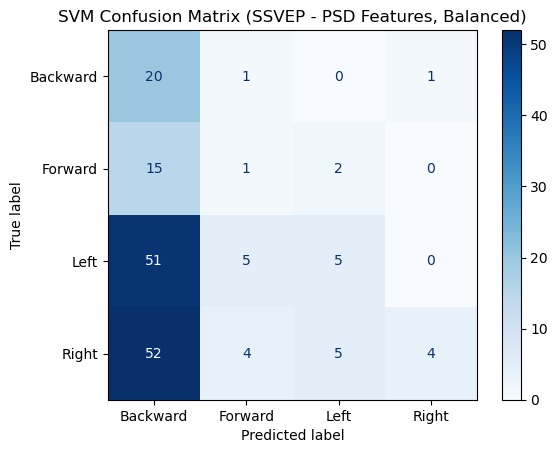

[RESULT] RandomForest Validation Accuracy (PSD, Balanced): 0.2651


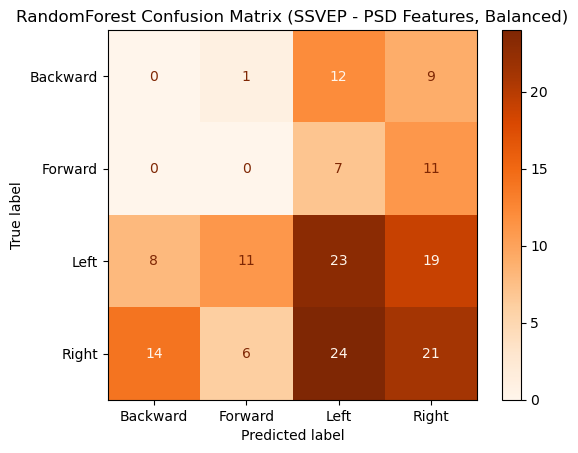

In [16]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from scipy.signal import welch
from collections import Counter

# --- SETTINGS ---
base_dir = r"C:\Users\zezom\PycharmProjects\HorusEye"
csv_data_dir = os.path.join(base_dir, "Data", "Processed", "SSVEP")
labels_path = os.path.join(base_dir, "train.csv")
samples_per_trial = 1750
sampling_rate = 250  # Hz
ssvep_labels = ['Forward', 'Backward', 'Left', 'Right']

# --- SSVEP parameters (adjust freq list to match your experiment) ---
target_freqs = [8, 10, 12, 15]  # Hz, change if your SSVEP stimuli are different
freq_window = 0.5
occipital_channels = ['OZ_ref', 'PO7_ref', 'PO8_ref', 'PZ_ref']

# --- Load Labels ---
labels_df = pd.read_csv(labels_path)
labels_df.columns = labels_df.columns.str.strip()
ssvep_df = labels_df[labels_df['label'].isin(ssvep_labels)]
print(f"[INFO] Total SSVEP trials found: {len(ssvep_df)}")

# --- Extract SSVEP PSD Features ---
X = []
y = []
skipped_missing_channel = 0
skipped_samples = 0

for i, row in ssvep_df.iterrows():
    subject = str(row['subject_id']).strip()
    session = str(row['trial_session']).strip()
    trial_num = int(row['trial'])
    label = row['label'].strip()
    csv_path = os.path.join(csv_data_dir, f"{subject}_{session}_EEGdata_preprocessed.csv")
    if not os.path.exists(csv_path):
        continue

    try:
        df = pd.read_csv(csv_path)
        channels = [c for c in df.columns if c in occipital_channels]
        if len(channels) != len(occipital_channels):
            skipped_missing_channel += 1
            if skipped_missing_channel <= 5:
                print(f"[WARN] Occipital channels missing in {csv_path}: found {channels}")
            continue  # skip if not all occipital channels present
        start_idx = (trial_num - 1) * samples_per_trial
        end_idx = trial_num * samples_per_trial
        trial_data = df[channels].iloc[start_idx:end_idx].values
        if trial_data.shape[0] != samples_per_trial:
            skipped_samples += 1
            if skipped_samples <= 5:
                print(f"[WARN] Incomplete trial {trial_num} in {csv_path}")
            continue

        # --- PSD at SSVEP Frequencies ---
        psd_features = []
        for ch in range(trial_data.shape[1]):
            freqs, psd = welch(trial_data[:, ch], fs=sampling_rate, nperseg=256)
            for target in target_freqs:
                mask = (freqs >= (target - freq_window)) & (freqs <= (target + freq_window))
                psd_features.append(np.mean(psd[mask]))
        X.append(psd_features)
        y.append(label)
    except Exception as e:
        print(f"[ERROR] {csv_path}, Trial {trial_num}: {e}")

if skipped_missing_channel > 0:
    print(f"[SUMMARY] Skipped {skipped_missing_channel} trials missing occipital channels.")
if skipped_samples > 0:
    print(f"[SUMMARY] Skipped {skipped_samples} trials with incomplete samples.")

# --- Final Preprocessing ---
if len(X) == 0:
    raise RuntimeError("No valid data loaded! Check occipital channel names, and that at least some files contain all of them.")

X = np.array(X)
y = np.array(y)
print(f"[INFO] Final improved dataset shape: {X.shape}, Labels: {np.unique(y)}")
print("Class counts (full):", Counter(y))

# --- Encode Labels ---
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
print("Train counts:", Counter(y_train))
print("Test counts:", Counter(y_test))

# --- SVM: Class Weights & Training ---
svm_model = SVC(kernel='rbf', C=1, gamma='scale', class_weight='balanced')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
acc_svm = accuracy_score(y_test, y_pred_svm)
print(f"[RESULT] SVM Validation Accuracy (PSD, Balanced): {acc_svm:.4f}")

cm_svm = confusion_matrix(y_test, y_pred_svm)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=label_encoder.classes_)
disp_svm.plot(cmap='Blues')
plt.title("SVM Confusion Matrix (SSVEP - PSD Features, Balanced)")
plt.show()

# --- RANDOM FOREST: Also Try for Tabular Data! ---
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"[RESULT] RandomForest Validation Accuracy (PSD, Balanced): {acc_rf:.4f}")

cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=label_encoder.classes_)
disp_rf.plot(cmap='Oranges')
plt.title("RandomForest Confusion Matrix (SSVEP - PSD Features, Balanced)")
plt.show()


Channels in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\SSVEP\S30_8_EEGdata_preprocessed.csv : ['FZ_ref', 'C3_ref', 'CZ_ref', 'C4_ref', 'PZ_ref', 'PO7_ref', 'OZ_ref', 'PO8_ref']


In [16]:
import pickle

# ... [your code above this line, unchanged]

# --- Save SVM Model and Label Encoder ---
model_save_dir = os.path.join(base_dir, "Models")
os.makedirs(model_save_dir, exist_ok=True)
svm_path = os.path.join(model_save_dir, "svm_ssvep_model.pkl")
encoder_path = os.path.join(model_save_dir, "svm_ssvep_label_encoder.pkl")

# Save model
with open(svm_path, "wb") as f:
    pickle.dump(svm_model, f)
print(f"[INFO] SVM model saved to {svm_path}")

# Save label encoder
with open(encoder_path, "wb") as f:
    pickle.dump(label_encoder, f)
print(f"[INFO] Label encoder saved to {encoder_path}")

# --- If you add scaling, also save the scaler! ---
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# ... fit/transform code ...
# scaler_path = os.path.join(model_save_dir, "svm_ssvep_scaler.pkl")
# with open(scaler_path, "wb") as f:
#     pickle.dump(scaler, f)
# print(f"[INFO] Scaler saved to {scaler_path}")


[INFO] SVM model saved to C:\Users\zezom\PycharmProjects\HorusEye\Models\svm_ssvep_model.pkl
[INFO] Label encoder saved to C:\Users\zezom\PycharmProjects\HorusEye\Models\svm_ssvep_label_encoder.pkl


In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from scipy.signal import welch

# --- SETTINGS ---
base_dir = r"C:\Users\zezom\PycharmProjects\HorusEye"
csv_data_dir = os.path.join(base_dir, "Data", "Processed", "SSVEP")
labels_path = os.path.join(base_dir, "train.csv")
samples_per_trial = 1750
sampling_rate = 250  # Hz
ssvep_labels = ['Forward', 'Backward', 'Left', 'Right']

# --- Load Labels ---
labels_df = pd.read_csv(labels_path)
labels_df.columns = labels_df.columns.str.strip()
ssvep_df = labels_df[labels_df['label'].isin(ssvep_labels)]
print(f"[INFO] Total SSVEP trials found: {len(ssvep_df)}")

# --- Load EEG Trials and Extract PSD Features ---
X = []
y = []

for i, row in ssvep_df.iterrows():
    subject = str(row['subject_id']).strip()
    session = str(row['trial_session']).strip()
    trial_num = int(row['trial'])
    label = row['label'].strip()

    csv_path = os.path.join(csv_data_dir, f"{subject}_{session}_EEGdata_preprocessed.csv")
    if not os.path.exists(csv_path):
        continue

    try:
        df = pd.read_csv(csv_path)
        start_idx = (trial_num - 1) * samples_per_trial
        end_idx = trial_num * samples_per_trial
        trial_data = df.iloc[start_idx:end_idx].values  # (1750, 8)

        if trial_data.shape[0] != samples_per_trial:
            continue

        # --- PSD Extraction ---
        psd_features = []
        for ch in range(trial_data.shape[1]):
            freqs, psd = welch(trial_data[:, ch], fs=sampling_rate, nperseg=256)
            # Use only 5-45 Hz band
            band = (freqs >= 5) & (freqs <= 45)
            psd_features.extend(psd[band])

        X.append(psd_features)
        y.append(label)

    except Exception as e:
        print(f"[ERROR] {csv_path}, Trial {trial_num}: {e}")

# --- Final Preprocessing ---
if len(X) == 0:
    raise RuntimeError("No valid data loaded!")

X = np.array(X)
y = np.array(y)
print(f"[INFO] Final dataset shape: {X.shape}, Labels: {np.unique(y)}")

# --- Encode Labels ---
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# --- SVM Hyperparameter Grid ---
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.05, 0.1, 0.5, 1],
    'kernel': ['rbf', 'linear', 'poly']
}

# --- Hyperparameter Tuning ---
svm = SVC()
grid_search = GridSearchCV(
    svm,
    param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)

print(f"[INFO] Best Params: {grid_search.best_params_}")
print(f"[INFO] Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

# --- Evaluate Best Model ---
best_svm = grid_search.best_estimator_
y_pred = best_svm.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"[RESULT] SVM Validation Accuracy (PSD, Tuned): {acc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title("SVM Confusion Matrix (SSVEP - PSD Features, Tuned)")
plt.show()

# --- Save Best Model and LabelEncoder for later use ---
import pickle
svm_model_path = os.path.join(base_dir, "ssvep_best_svm_psd.pkl")
encoder_path = os.path.join(base_dir, "ssvep_label_encoder.pkl")
with open(svm_model_path, "wb") as f:
    pickle.dump(best_svm, f)
with open(encoder_path, "wb") as f:
    pickle.dump(label_encoder, f)
print(f"[INFO] Best SVM model saved to: {svm_model_path}")
print(f"[INFO] Label encoder saved to: {encoder_path}")


[INFO] Total SSVEP trials found: 4800


KeyboardInterrupt: 

# Deep Learning Model

[SKIP] Empty index in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\SSVEP\DL_ready\S10_3_EEGdata_preprocessed_index.csv
[SKIP] Empty array in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\SSVEP\DL_ready\S10_4_EEGdata_preprocessed_DLready.npy
[SKIP] Empty index in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\SSVEP\DL_ready\S10_5_EEGdata_preprocessed_index.csv
[SKIP] Empty index in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\SSVEP\DL_ready\S10_6_EEGdata_preprocessed_index.csv
[SKIP] Empty index in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\SSVEP\DL_ready\S10_7_EEGdata_preprocessed_index.csv
[SKIP] Empty index in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\SSVEP\DL_ready\S11_1_EEGdata_preprocessed_index.csv
[SKIP] Empty index in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\SSVEP\DL_ready\S11_2_EEGdata_preprocessed_index.csv
[SKIP] Empty index in C:\Users\zezom\PycharmProjects\HorusEye\Data\Processed\SSVEP\DL_ready\S11

C:\Users\zezom\miniconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 32, 1750)       │         3,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 1750)       │         7,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 1750)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 32, 875)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 875)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 64, 875)        │        14,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 875)        │         3,500 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 64, 875)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 64, 437)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64, 437)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 27968)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,790,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,819,048 (6.94 MB)

 Trainable params: 1,813,798 (6.92 MB)

 Non-trainable params: 5,250 (20.51 KB)

Epoch 1/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - accuracy: 0.2538 - loss: 4.5266 - val_accuracy: 0.2289 - val_loss: 1.3864
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 0.2115 - loss: 1.3863 - val_accuracy: 0.2169 - val_loss: 1.3865
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 166ms/step - accuracy: 0.2145 - loss: 1.3876 - val_accuracy: 0.2169 - val_loss: 1.3865
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.2145 - loss: 1.3863 - val_accuracy: 0.2169 - val_loss: 1.3865
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 150ms/step - accuracy: 0.2145 - loss: 1.3863 - val_accuracy: 0.2169 - val_loss: 1.3865
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.2145 - loss: 1.3863 - val_accuracy: 0.2169 - val_loss: 1.3866
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 163ms/step - accuracy: 0.2145 - loss: 1.3863 - val_accuracy: 0.2169 - val_loss: 1.3866
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 162ms/step - accuracy: 0.2145 - loss: 1.3864 - val_accuracy: 0.

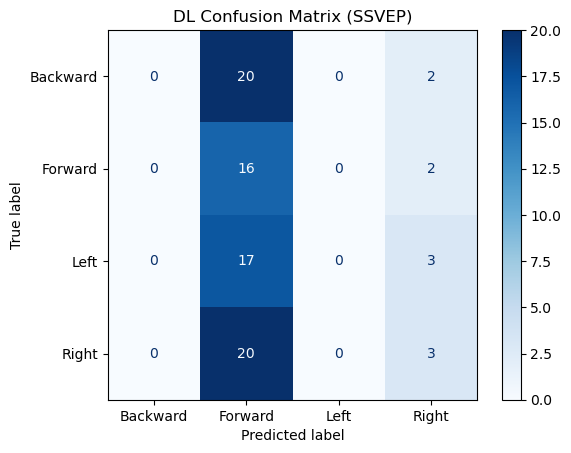

In [9]:
import os
import numpy as np
import pandas as pd
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, Activation, Dropout, MaxPooling1D, Flatten, Dense, InputLayer
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter

# --- SETTINGS ---
base_dir = r"C:\Users\zezom\PycharmProjects\HorusEye"
dl_ready_dir = os.path.join(base_dir, "Data", "Processed", "SSVEP", "DL_ready")
labels_path = os.path.join(base_dir, "train.csv")
ssvep_labels = ['Forward', 'Backward', 'Left', 'Right']

# --- LOAD LABELS ---
labels_df = pd.read_csv(labels_path)
labels_df.columns = labels_df.columns.str.strip()
ssvep_df = labels_df[labels_df['label'].isin(ssvep_labels)]

# --- LOAD DL_ready FILES ---
all_dl_files = sorted(glob(os.path.join(dl_ready_dir, '*_EEGdata_preprocessed_DLready.npy')))
all_index_files = sorted(glob(os.path.join(dl_ready_dir, '*_EEGdata_preprocessed_index.csv')))

X_list = []
meta_list = []

for npy_path, idx_path in zip(all_dl_files, all_index_files):
    data = np.load(npy_path, allow_pickle=True)
    if isinstance(data, np.ndarray) and data.dtype == object:
        if len(data) == 0:
            print(f"[SKIP] Empty array in {npy_path}")
            continue
        data = np.stack(data)
    if data.ndim == 4:
        data = data[..., 0]
    index_df = pd.read_csv(idx_path)
    if index_df.shape[0] == 0:
        print(f"[SKIP] Empty index in {idx_path}")
        continue
    # Robust column autodetect
    cols = index_df.columns.str.lower()
    subj_col = [c for c in cols if 'subject' in c][0]
    sess_col = [c for c in cols if 'session' in c][0]
    trial_col = [c for c in cols if 'trial' in c][0]
    for i, row in index_df.iterrows():
        meta_list.append({
            'subject_id': str(row[subj_col]).strip(),
            'trial_session': str(row[sess_col]).strip(),
            'trial': int(row[trial_col])
        })
    X_list.append(data)

if not X_list:
    raise RuntimeError("No valid SSVEP data found in DL_ready!")

X_all = np.concatenate(X_list, axis=0)
meta_df = pd.DataFrame(meta_list)
print("[INFO] Loaded data shape:", X_all.shape)
print("[INFO] Loaded meta shape:", meta_df.shape)

# --- MATCH LABELS ---
key_df = meta_df.copy()
key_df['key'] = (
    key_df['subject_id'].astype(str).str.strip() + "_" +
    key_df['trial_session'].astype(str).str.strip() + "_" +
    key_df['trial'].astype(str)
)
ssvep_df['key'] = (
    ssvep_df['subject_id'].astype(str).str.strip() + "_" +
    ssvep_df['trial_session'].astype(str).str.strip() + "_" +
    ssvep_df['trial'].astype(str)
)
key2label = dict(zip(ssvep_df['key'], ssvep_df['label']))
labels = [key2label.get(k, np.nan) for k in key_df['key']]
mask = [lbl in ssvep_labels for lbl in labels]
X_all = X_all[mask]
labels = np.array(labels)[mask]

# --- DEBUG: Label counts BEFORE SPLIT ---
print("[INFO] Filtered data shape:", X_all.shape)
label_counts = Counter(labels)
print("[INFO] Label counts FULL:", label_counts)

# --- NORMALIZE DATA (per trial) ---
X_all = (X_all - X_all.mean(axis=-1, keepdims=True)) / (X_all.std(axis=-1, keepdims=True) + 1e-6)

# --- ENCODE LABELS ---
le = LabelEncoder()
y_enc = le.fit_transform(labels)
y_cat = to_categorical(y_enc)
print("[INFO] Classes:", le.classes_)

# --- TRAIN-TEST SPLIT (STRATIFIED) ---
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

print("[INFO] Train set class counts:", np.sum(y_train, axis=0))
print("[INFO] Test set class counts:", np.sum(y_test, axis=0))
print("[INFO] Class order:", le.classes_)

# --- CLASS WEIGHTS ---
y_train_lbl = np.argmax(y_train, axis=1)
cw = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_lbl),
    y=y_train_lbl
)
class_weights = {i: cw[i] for i in range(len(cw))}
print("[INFO] Class weights:", class_weights)

# --- BUILD MODEL ---
n_channels = X_train.shape[1]
input_length = X_train.shape[2]
n_classes = y_cat.shape[1]

model = Sequential([
    InputLayer(input_shape=(n_channels, input_length)),
    Conv1D(32, kernel_size=15, padding='same', data_format='channels_first'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling1D(pool_size=2, data_format='channels_first'),
    Dropout(0.3),
    Conv1D(64, kernel_size=7, padding='same', data_format='channels_first'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling1D(pool_size=2, data_format='channels_first'),
    Dropout(0.3),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# --- TRAIN ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=40,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=8, restore_best_weights=True)]
)

model.save('ssvep_cnn_model.keras')
print("Model saved as ssvep_cnn_model.keras")

# --- EVALUATE ---
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"[RESULT] Deep Learning Validation Accuracy (SSVEP): {test_acc:.4f}")

y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("DL Confusion Matrix (SSVEP)")
plt.show()


# EEGNet Style

Epoch 1/100
81/81 - 12s - 149ms/step - accuracy: 0.4103 - loss: 1.2441 - val_accuracy: 0.3800 - val_loss: 1.3527
Epoch 2/100
81/81 - 12s - 145ms/step - accuracy: 0.4247 - loss: 1.1777 - val_accuracy: 0.3705 - val_loss: 1.3245
Epoch 3/100
81/81 - 10s - 127ms/step - accuracy: 0.4216 - loss: 1.1856 - val_accuracy: 0.3800 - val_loss: 1.2931
Epoch 4/100
81/81 - 10s - 123ms/step - accuracy: 0.4251 - loss: 1.1542 - val_accuracy: 0.3800 - val_loss: 1.2723
Epoch 5/100
81/81 - 10s - 123ms/step - accuracy: 0.4353 - loss: 1.1522 - val_accuracy: 0.3800 - val_loss: 1.2606
Epoch 6/100
81/81 - 10s - 124ms/step - accuracy: 0.4216 - loss: 1.1579 - val_accuracy: 0.3705 - val_loss: 1.2566
Epoch 7/100
81/81 - 10s - 124ms/step - accuracy: 0.4294 - loss: 1.1515 - val_accuracy: 0.3705 - val_loss: 1.2546
Epoch 8/100
81/81 - 10s - 124ms/step - accuracy: 0.4169 - loss: 1.1393 - val_accuracy: 0.3800 - val_loss: 1.2539
Epoch 9/100
81/81 - 10s - 124ms/step - accuracy: 0.4239 - loss: 1.1350 - val_accuracy: 0.3800 - 

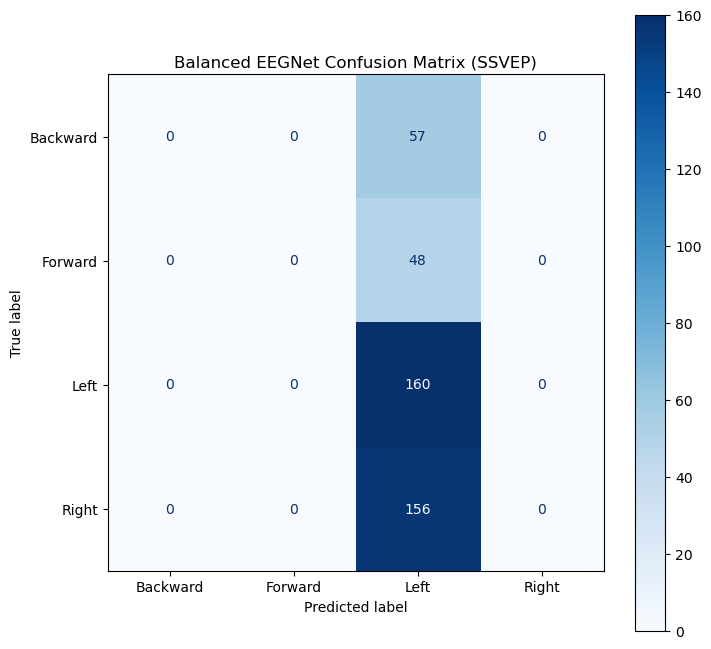

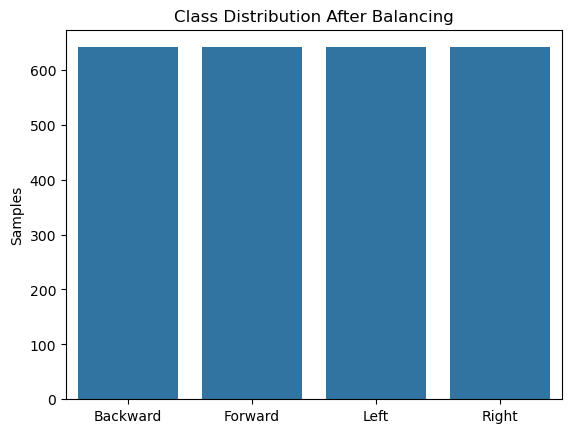

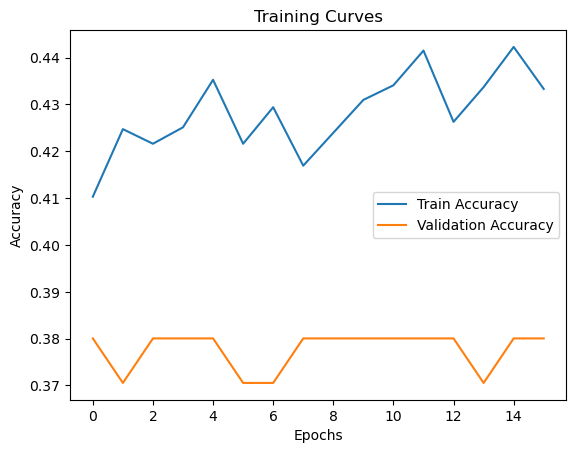

Model saved as balanced_ssvep_eegnet_final.keras


In [31]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
from keras.models import Model
from keras.layers import (Input, Conv2D, DepthwiseConv2D, SeparableConv2D,
                          BatchNormalization, Activation, AveragePooling2D,
                          Dropout, Flatten, Dense)
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tensorflow as tf
import os

# --- Load and Prepare Data ---
base_dir = r"C:\Users\zezom\PycharmProjects\HorusEye"
data_dir = os.path.join(base_dir, "Data", "Processed", "SSVEP")
labels_df = pd.read_csv(os.path.join(base_dir, "train.csv")).dropna()

ssvep_labels = ['Backward', 'Forward', 'Left', 'Right']
labels_df = labels_df[labels_df['label'].isin(ssvep_labels)]

channels = ['C3_ref', 'CZ_ref', 'C4_ref', 'OZ_ref']
samples_per_trial = 1750

X, y = [], []
for _, row in labels_df.iterrows():
    file = f"{row['subject_id']}_{row['trial_session']}_EEGdata_preprocessed.csv"
    path = os.path.join(data_dir, file)
    if not os.path.exists(path):
        continue
    df = pd.read_csv(path)
    start = (row['trial'] - 1) * samples_per_trial
    end = row['trial'] * samples_per_trial
    trial_data = df[channels].iloc[start:end].values.T
    if trial_data.shape[1] == samples_per_trial:
        X.append(trial_data)
        y.append(row['label'])

X = np.array(X)[..., np.newaxis]
X = (X - np.mean(X, axis=-1, keepdims=True)) / (np.std(X, axis=-1, keepdims=True) + 1e-6)

le = LabelEncoder()
y_enc = le.fit_transform(y)
y_cat = to_categorical(y_enc)

# --- Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, stratify=y_cat, test_size=0.2, random_state=42)

# --- Improved Balanced Augmentation ---
def balanced_augment_eeg(X, y, noise_std=0.1):
    counts = Counter(y)
    max_count = max(counts.values())
    X_aug, y_aug = [], []
    for label in np.unique(y):
        label_indices = np.where(y == label)[0]
        samples_needed = max_count - counts[label]
        selected = np.random.choice(label_indices, samples_needed, replace=True)
        for idx in selected:
            augmented_sample = X[idx] + np.random.normal(0, noise_std, X[idx].shape)
            shift = np.random.randint(-50, 50)
            augmented_sample = np.roll(augmented_sample, shift, axis=1)
            X_aug.append(augmented_sample)
            y_aug.append(label)
    return np.array(X_aug), np.array(y_aug)

y_train_labels = np.argmax(y_train, axis=1)
X_aug, y_aug = balanced_augment_eeg(X_train, y_train_labels)

X_train_balanced = np.concatenate([X_train, X_aug])
y_train_balanced = np.concatenate([y_train_labels, y_aug])
y_train_balanced_cat = to_categorical(y_train_balanced)

# --- Updated Class Weights ---
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
class_weights = dict(enumerate(class_weights))

# --- EEGNet Optimized ---
def EEGNet(nb_classes, Chans=4, Samples=1750, dropoutRate=0.5, kernLength=64, F1=16, D=2, F2=32):
    input_layer = Input((Chans, Samples, 1))
    block1 = Conv2D(F1, (1, kernLength), padding='same', use_bias=False)(input_layer)
    block1 = BatchNormalization()(block1)
    block1 = DepthwiseConv2D((Chans, 1), depth_multiplier=D, use_bias=False)(block1)
    block1 = BatchNormalization()(block1)
    block1 = Activation('elu')(block1)
    block1 = AveragePooling2D((1, 4))(block1)
    block1 = Dropout(dropoutRate)(block1)

    block2 = SeparableConv2D(F2, (1, 16), padding='same', use_bias=False)(block1)
    block2 = BatchNormalization()(block2)
    block2 = Activation('elu')(block2)
    block2 = AveragePooling2D((1, 8))(block2)
    block2 = Dropout(dropoutRate)(block2)

    flatten = Flatten()(block2)
    output = Dense(nb_classes, activation='softmax')(flatten)

    return Model(input_layer, output)

model = EEGNet(nb_classes=4)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# --- Callbacks ---
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True),
    ModelCheckpoint("balanced_ssvep_eegnet_final.keras", monitor='val_accuracy', save_best_only=True)
]

# --- Training ---
history = model.fit(
    X_train_balanced, y_train_balanced_cat,
    epochs=100, batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=2
)

# --- Evaluate ---
y_pred_labels = np.argmax(model.predict(X_test), axis=1)
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred_labels)
print(f"Final Balanced Accuracy: {accuracy:.4f}")

# --- Confusion Matrix ---
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap='Blues')
plt.title('Balanced EEGNet Confusion Matrix (SSVEP)')
plt.show()

# --- Class Distribution after Augmentation ---
sns.barplot(x=le.classes_, y=[np.sum(y_train_balanced == i) for i in range(4)])
plt.title("Class Distribution After Balancing")
plt.ylabel("Samples")
plt.show()

# --- Training Curves ---
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# --- Save the Balanced Model ---
model.save("balanced_ssvep_eegnet_final.keras")
print("Model saved as balanced_ssvep_eegnet_final.keras")


C:\Users\zezom\miniconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
125/125 - 14s - 115ms/step - accuracy: 0.2645 - loss: 1.3865 - val_accuracy: 0.2779 - val_loss: 1.3873
Epoch 2/100
125/125 - 3s - 21ms/step - accuracy: 0.3080 - loss: 1.3769 - val_accuracy: 0.2209 - val_loss: 1.3931
Epoch 3/100
125/125 - 3s - 22ms/step - accuracy: 0.3577 - loss: 1.3627 - val_accuracy: 0.2185 - val_loss: 1.3942
Epoch 4/100
125/125 - 3s - 23ms/step - accuracy: 0.4235 - loss: 1.3326 - val_accuracy: 0.2162 - val_loss: 1.4050
Epoch 5/100
125/125 - 7s - 57ms/step - accuracy: 0.4453 - loss: 1.2722 - val_accuracy: 0.2447 - val_loss: 1.4633
Epoch 6/100
125/125 - 3s - 22ms/step - accuracy: 0.5023 - loss: 1.1724 - val_accuracy: 0.2447 - val_loss: 1.5337
Epoch 7/100
125/125 - 3s - 22ms/step - accuracy: 0.5285 - loss: 1.0717 - val_accuracy: 0.2375 - val_loss: 1.6728
Epoch 8/100
125/125 - 3s - 22ms/step - accuracy: 0.5742 - loss: 0.9981 - val_accuracy: 0.2185 - val_loss: 1.7680
Epoch 9/100
125/125 - 3s - 21ms/step - accuracy: 0.5918 - loss: 0.9464 - val_accuracy: 0.2375 

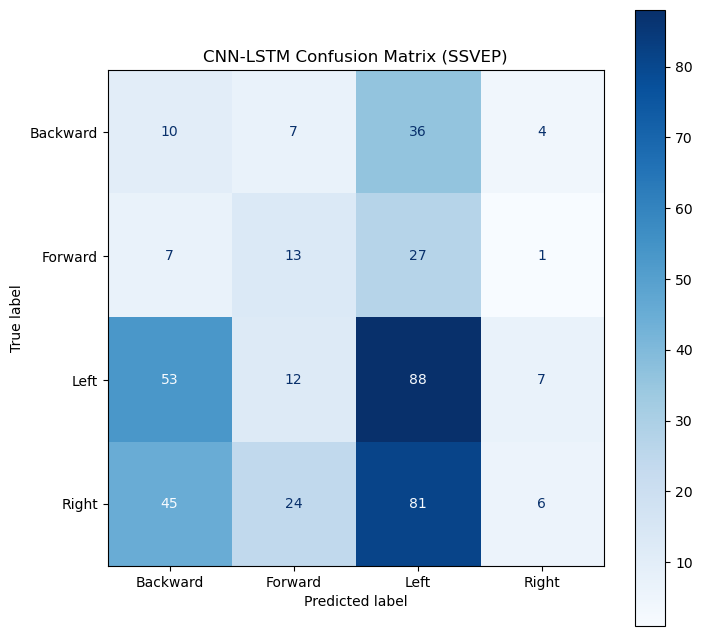

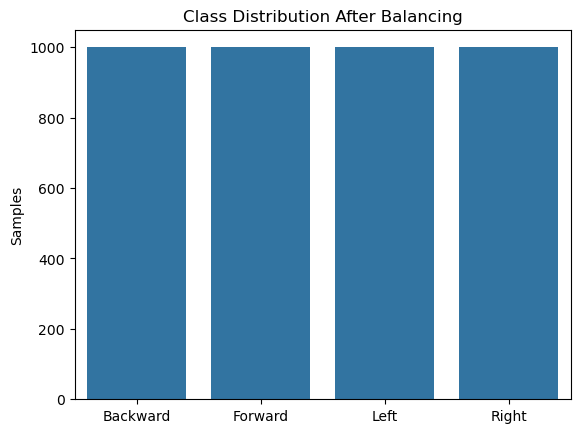

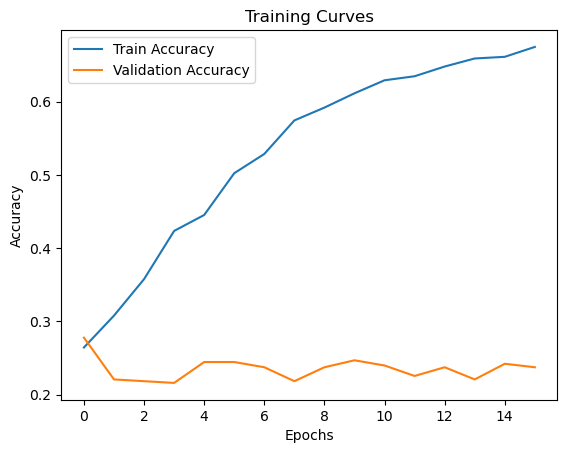

Model saved as cnn_lstm_ssvep_final.keras


In [33]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import (Conv1D, BatchNormalization, LSTM, Dense, Dropout, Flatten, InputLayer)
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tensorflow as tf
import os

# Load and Prepare Data
base_dir = r"C:\Users\zezom\PycharmProjects\HorusEye"
data_dir = os.path.join(base_dir, "Data", "Processed", "SSVEP")
labels_df = pd.read_csv(os.path.join(base_dir, "train.csv")).dropna()

ssvep_labels = ['Backward', 'Forward', 'Left', 'Right']
labels_df = labels_df[labels_df['label'].isin(ssvep_labels)]

channels = ['C3_ref', 'CZ_ref', 'C4_ref', 'OZ_ref']
samples_per_trial = 1750

X, y = [], []
for _, row in labels_df.iterrows():
    file = f"{row['subject_id']}_{row['trial_session']}_EEGdata_preprocessed.csv"
    path = os.path.join(data_dir, file)
    if not os.path.exists(path):
        continue
    df = pd.read_csv(path)
    start = (row['trial'] - 1) * samples_per_trial
    end = row['trial'] * samples_per_trial
    trial_data = df[channels].iloc[start:end].values.T
    if trial_data.shape[1] == samples_per_trial:
        X.append(trial_data)
        y.append(row['label'])

X = np.array(X)
X = (X - X.mean(axis=-1, keepdims=True)) / (X.std(axis=-1, keepdims=True) + 1e-6)

le = LabelEncoder()
y_enc = le.fit_transform(y)
y_cat = to_categorical(y_enc)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, stratify=y_cat, test_size=0.2, random_state=42
)

# Balanced Data Augmentation
def balanced_augment(X, y, target_samples=1000, noise_std=0.05):
    unique_labels = np.unique(y)
    X_aug, y_aug = [], []
    for label in unique_labels:
        indices = np.where(y == label)[0]
        needed = target_samples - len(indices)
        selected = np.random.choice(indices, needed, replace=True)
        for idx in selected:
            augmented = X[idx] + np.random.normal(0, noise_std, X[idx].shape)
            shift = np.random.randint(-50, 50)
            augmented = np.roll(augmented, shift, axis=1)
            X_aug.append(augmented)
            y_aug.append(label)
    return np.array(X_aug), np.array(y_aug)

y_train_labels = np.argmax(y_train, axis=1)
X_aug, y_aug = balanced_augment(X_train, y_train_labels)

X_train_balanced = np.concatenate([X_train, X_aug])
y_train_balanced = np.concatenate([y_train_labels, y_aug])
y_train_balanced_cat = to_categorical(y_train_balanced)

# Class Weights
class_weights = compute_class_weight(
    'balanced', classes=np.unique(y_train_balanced), y=y_train_balanced
)
class_weights = dict(enumerate(class_weights))

# Model: CNN-LSTM
model = Sequential([
    InputLayer(input_shape=(len(channels), samples_per_trial)),
    Conv1D(32, kernel_size=7, activation='relu', padding='same'),
    BatchNormalization(),
    Conv1D(64, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_accuracy'),
    ModelCheckpoint("cnn_lstm_ssvep.keras", monitor='val_accuracy', save_best_only=True)
]

# Training
history = model.fit(
    X_train_balanced, y_train_balanced_cat,
    epochs=100, batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=2
)

# Evaluate
y_pred_labels = np.argmax(model.predict(X_test), axis=1)
y_true_labels = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true_labels, y_pred_labels)
print(f"Final Balanced Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)
disp = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap='Blues')
plt.title('CNN-LSTM Confusion Matrix (SSVEP)')
plt.show()

# Class Distribution after Balancing
sns.barplot(x=le.classes_, y=[np.sum(y_train_balanced == i) for i in range(4)])
plt.title("Class Distribution After Balancing")
plt.ylabel("Samples")
plt.show()

# Training Curves
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save Final Model
model.save("cnn_lstm_ssvep_final.keras")
print("Model saved as cnn_lstm_ssvep_final.keras")
